# Environment Setup

In [1]:
import sys
import os

if 'kaggle_web_client' in sys.modules:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    HUGGINGFACE_API_KEY = user_secrets.get_secret("HUGGINGFACE_API_KEY")
elif 'google.colab' in sys.modules:
    !pip -q install python-dotenv
    from dotenv import load_dotenv
    load_dotenv()
    HUGGINGFACE_API_KEY = os.getenv('HUGGINGFACE_API_KEY')

else:
    from dotenv import load_dotenv
    load_dotenv()
    HUGGINGFACE_API_KEY = os.getenv('HUGGINGFACE_API_KEY')

In [2]:
!pip -q install huggingface_hub

from huggingface_hub import notebook_login
from huggingface_hub import login
login(token=HUGGINGFACE_API_KEY, write_permission=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.0 MB/s eta 0:00:00
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
# check if the environment is kaggle, colab or local
if "kaggle_web_client" in sys.modules:
    BASE_DIR = "/kaggle/input/qlora-t5-openorca"
elif "google.colab" in sys.modules:
    BASE_DIR = "/content"
else:
    BASE_DIR = "data"

# install libraries

In [4]:
if  'google.colab' in sys.modules:
    !pip -q install datasets
    !pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00


# imports

In [5]:
from datasets import load_dataset

import datasets

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset  (Open-Orca/OpenOrca)

 This rich collection of augmented FLAN data aligns, as best as possible, with the distributions outlined in the [Orca paper](https://arxiv.org/abs/2306.02707). It has been instrumental in generating high-performing model checkpoints and serves as a valuable resource for all NLP researchers and developers!

 ## Data Summary

The OpenOrca dataset is a collection of augmented [FLAN Collection data](https://arxiv.org/abs/2301.13688). Currently ~1M GPT-4 completions, and ~3.2M GPT-3.5 completions. It is tabularized in alignment with the distributions presented in the ORCA paper and currently represents a partial completion of the full intended dataset, with ongoing generation to expand its scope. The data is primarily used for training and evaluation in the field of natural language processing.

## Data Instances

A data instance in this dataset represents entries from the FLAN collection which have been augmented by submitting the listed question to either GPT-4 or GPT-3.5. The response is then entered into the response field.

## Data Fields

The fields are:

'id', a unique numbered identifier which includes one of 'niv', 't0', 'cot', or 'flan' to represent which source FLAN Collection submix the 'question' is sourced from.

'system_prompt', representing the System Prompt presented to the GPT-3.5 or GPT-4 API for the datapoint

'question', representing a question entry as provided by the FLAN Collection

'response', a response to that question received from a query to either GPT-3.5 or GPT-4.


In [ ]:
raw_data = load_dataset("Open-Orca/OpenOrca")

In [ ]:
raw_train_dataset = raw_data["train"]
raw_train_dataset.features

{'id': Value(dtype='string', id=None),
 'system_prompt': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'response': Value(dtype='string', id=None)}

In [ ]:
data_len = len(raw_train_dataset)
data_len

4233923

# Load Tokenizer

In [ ]:
from transformers import AutoTokenizer

checkpoint = "t5-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


# Experiment with the data

In [ ]:
# # Initialize an empty list to store the tokenized lengths
# prompt_tokenized_lengths = []
# que_tokenized_lengths = []

# # Set the batch size
# batch_size = 5000

# # Iterate through the dataset in batches
# for i in tqdm(range(0, data_len, batch_size)):
#     # Get the current batch of sentences
#     sentences = raw_train_dataset[i:i+batch_size]


#     tokenized_sentences = tokenizer(sentences["system_prompt"], sentences["question"])


#     prompt_tokenized_lengths.extend([len(tokenized_sentence) for tokenized_sentence in tokenized_sentences['input_ids']])

In [ ]:
# global input_len

input_len = pd.read_csv(os.path.join(BASE_DIR, "samples_length.csv"))
# input_len.head().drop()
input_len = input_len.drop(["Unnamed: 0"], axis=1)
input_len.head()

,length
0,182
1,87
2,189
3,163
4,70


In [ ]:
input_len.shape

(4233923, 1)

In [ ]:
raw_train_dataset = raw_train_dataset.add_column(
    "length_before_preprocessing", input_len["length"]
)

In [ ]:
raw_train_dataset[0]["length_before_preprocessing"]

182

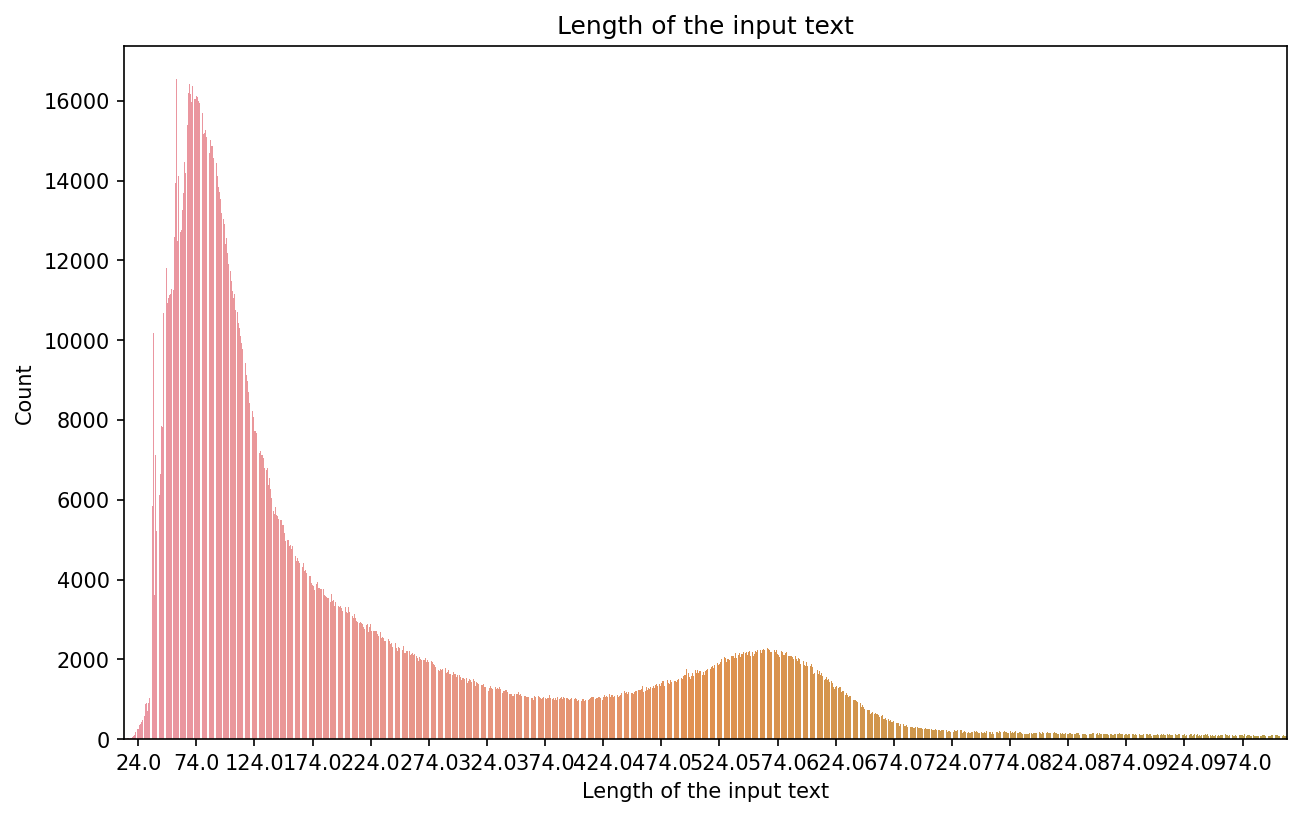

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)

sns.countplot(x="length", data=input_len)
plt.title("Length of the input text")
plt.xlabel("Length of the input text")
plt.ylabel("Count")

plt.xticks(np.arange(12, 1000, 50))
plt.xlim(0, 1000)

## Prompt Modification

In [ ]:
# get the unique prompts in which the total length is more than 512

unique_prompts = set()

for indx, len_ in enumerate(input_len["length"]):
    if len_ > 512:
        unique_prompts.add(raw_train_dataset[indx]["system_prompt"])

In [ ]:
global unique_prompts_df

unique_prompts_df = pd.DataFrame(columns=["prompt", "length"])

for indx, prompt in enumerate(unique_prompts):
    unique_prompts_df.loc[indx] = [prompt, len(prompt.split())]

In [ ]:
unique_prompts_df

,prompt,length
0,,0
1,"You are a teacher. Given a task, you explain i...",31
2,User will you give you a task with some instru...,29
3,You are an AI assistant that helps people find...,10
4,You are an AI assistant that follows instructi...,16
5,You are an AI assistant. You will be given a t...,19
6,Given a definition of a task and a sample inpu...,70
7,You are an AI assistant. Provide a detailed an...,20
8,"You are an AI assistant, who knows every langu...",50
9,Explain how you used the definition to come up...,12


In [ ]:
unique_prompts_df = unique_prompts_df.iloc[1:]

In [ ]:
unique_prompts_df = unique_prompts_df.reset_index(drop=True)

- Let's change the prompt to reduce the length of the prompt, so that we can get the input text under 512 tokens

---

In [ ]:
modified_prompts = []

In [ ]:
unique_prompts_df["prompt"].iloc[0]

'You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer.'

In [ ]:
text = "As a teacher, Explain what task is asking, any guidelines it provides and how to use those guidelines to find the answer."
len(text.split())

22

In [ ]:
modified_prompts.append(text)

---

In [ ]:
unique_prompts_df["prompt"].iloc[1]

'User will you give you a task with some instruction. Your job is follow the instructions as faithfully as you can. While answering think step-by-step and justify your answer.'

In [ ]:
text = "You will be given task and instructions. Follow instructions and answer step-by-step and Justify your answer."

len(text.split())

16

In [ ]:
modified_prompts.append(text)

---

In [ ]:
unique_prompts_df["prompt"].iloc[2]

'You are an AI assistant that helps people find information.'

In [ ]:
text = "Act as information finding AI assistant"

len(text.split())

6

In [ ]:
modified_prompts.append(text)

---

In [ ]:
unique_prompts_df["prompt"].iloc[3]

'You are an AI assistant that follows instruction extremely well. Help as much as you can.'

In [ ]:
text = "You are instruction follower AI. Help me."

len(text.split())

7

In [ ]:
modified_prompts.append(text)

---

In [ ]:
unique_prompts_df["prompt"].iloc[4]

'You are an AI assistant. You will be given a task. You must generate a detailed and long answer.'

In [ ]:
text = "As an AI assitant generate a detailed and long answer."

len(text.split())

10

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[5])

Given a definition of a task and a sample input, break the definition into small parts.
Each of those parts will have some instruction. Explain their meaning by showing an example that meets the criteria in the instruction. Use the following format:
Part  # : a key part of the definition.
Usage: Sample response that meets the criteria from the key part. Explain why you think it meets the criteria.


In [ ]:
text = """Break down the given definition of task into small parts.
Each part will have some instruction. Explain the meaning with example. use the following format:
Part # : ker part of definition.
Usage: Sample response that meets instruction criteria, and explain why it meets."""

len(text.split())

44

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[6])

You are an AI assistant. Provide a detailed answer so user don't need to search outside to understand the answer.


In [ ]:
text = "As an AI assistant, provide detailed and complete answer."

len(text.split())

9

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[7])

You are an AI assistant, who knows every language and how to translate one language to another. Given a task, you explain in simple steps what the task is asking, any guidelines that it provides. You solve the task and show how you used the guidelines to solve the task.


In [ ]:
text = "As an AI translator who translate languages, Explain tasks in simple steps and any guidelines. Also show that how these guidelines are used to solve."

len(text.split())

25

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[8])

Explain how you used the definition to come up with the answer.


In [ ]:
text = "Explain you used definition to give answer."

len(text.split())

7

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[9])

You are an AI assistant that helps people find information. User will you give you a question. Your task is to answer as faithfully as you can. While answering think step-bystep and justify your answer.


In [ ]:
text = "As an AI assistant, Answer the qquestions asked by user. While answering think step-by-step and justify it."

len(text.split())

17

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[10])

You are an AI assistant that helps people find information. Provide a detailed answer so user don’t need to search outside to understand the answer.


In [ ]:
text = "As an AI assistant, provide detailed and complete answer."

len(text.split())

9

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[11])

You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.


In [ ]:
text = "Provide an explanation. Think like you are answering to five a year old."

len(text.split())

13

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[12])

You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. Think like you are answering to a five year old.


In [ ]:
text = "Describe the task and explain your answer to a five year old. While answering multiple choice question, first output correct answer(s). Then explain wrong ones."

len(text.split())

25

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[13])

You are an AI assistant. You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. You might need to use additional knowledge to answer the question.


In [ ]:
text = "Describe and explain your answer. WHile answering multiple choice question, first answer correct answer(s). Then explain the why other ar wrong. You may need additional knowledge."

len(text.split())

26

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[14])

You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.


In [ ]:
text = "As an AI assistant, provide detailed and completed answer."

len(text.split())

9

In [ ]:
modified_prompts.append(text)

---

In [ ]:
print(unique_prompts_df["prompt"].iloc[15])

You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.


In [ ]:
text = "As an AI assistant, your goal is to complete the given task faithfully. Answer step-by-step and justify your steps."

len(text.split())

19

In [ ]:
modified_prompts.append(text)

In [ ]:
len(modified_prompts)

16

In [ ]:
unique_prompts_df["modified_prompt"] = modified_prompts

In [ ]:
unique_prompts_df

,prompt,length,modified_prompt
0,"You are a teacher. Given a task, you explain i...",31,"As a teacher, Explain what task is asking, any..."
1,User will you give you a task with some instru...,29,You will be given task and instructions. Follo...
2,You are an AI assistant that helps people find...,10,Act as information finding AI assistant
3,You are an AI assistant that follows instructi...,16,You are instruction follower AI. Help me.
4,You are an AI assistant. You will be given a t...,19,As an AI assitant generate a detailed and long...
5,Given a definition of a task and a sample inpu...,70,Break down the given definition of task into s...
6,You are an AI assistant. Provide a detailed an...,20,"As an AI assistant, provide detailed and compl..."
7,"You are an AI assistant, who knows every langu...",50,"As an AI translator who translate languages, E..."
8,Explain how you used the definition to come up...,12,Explain you used definition to give answer.
9,You are an AI assistant that helps people find...,35,"As an AI assistant, Answer the qquestions aske..."


In [ ]:
new_len = []
for i in range(unique_prompts_df.shape[0]):
    new_len.append(len(unique_prompts_df["modified_prompt"].iloc[i].split()))

In [ ]:
unique_prompts_df["new_length"] = new_len

In [ ]:
unique_prompts_df

,prompt,length,modified_prompt,new_length
0,"You are a teacher. Given a task, you explain i...",31,"As a teacher, Explain what task is asking, any...",22
1,User will you give you a task with some instru...,29,You will be given task and instructions. Follo...,16
2,You are an AI assistant that helps people find...,10,Act as information finding AI assistant,6
3,You are an AI assistant that follows instructi...,16,You are instruction follower AI. Help me.,7
4,You are an AI assistant. You will be given a t...,19,As an AI assitant generate a detailed and long...,10
5,Given a definition of a task and a sample inpu...,70,Break down the given definition of task into s...,44
6,You are an AI assistant. Provide a detailed an...,20,"As an AI assistant, provide detailed and compl...",9
7,"You are an AI assistant, who knows every langu...",50,"As an AI translator who translate languages, E...",25
8,Explain how you used the definition to come up...,12,Explain you used definition to give answer.,7
9,You are an AI assistant that helps people find...,35,"As an AI assistant, Answer the qquestions aske...",17


## Go through the samples

- Giving both `prompt` and `question` together to the tokenizer

In [ ]:
index = 3

tokenizer(
    raw_train_dataset[index]["system_prompt"],
    raw_train_dataset[index]["question"],
    truncation=True,
)

{'input_ids': [148, 33, 46, 7833, 6165, 5, 148, 56, 36, 787, 3, 9, 2491, 5, 148, 398, 3806, 3, 9, 3117, 11, 307, 1525, 5, 1, 863, 1525, 8, 826, 822, 10, 27, 241, 12, 794, 8, 1418, 13, 481, 12, 608, 3, 9, 5454, 11, 1525, 746, 81, 34, 5, 9348, 25, 754, 369, 95, 28, 3, 9, 207, 822, 21, 8, 5454, 96, 1570, 29360, 6, 8, 14828, 13, 2051, 47, 8, 433, 57, 84, 8, 1296, 2450, 2390, 1044, 18, 19585, 27200, 13, 368, 1013, 10256, 6, 18838, 6, 1013, 2051, 6, 28020, 6, 7488, 11, 3782, 2051, 5147, 80, 2982, 5, 328, 2697, 8, 1002, 13, 789, 24, 79, 141, 1597, 38, 2450, 27200, 68, 92, 133, 43, 3, 9, 2822, 789, 24, 47, 1966, 21, 4573, 6238, 8, 829, 2982, 5, 366, 8, 11378, 13, 2051, 764, 139, 2054, 6, 8, 27200, 6018, 120, 1632, 2315, 13, 8, 21260, 13, 2051, 535, 58, 11801, 10, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
def split_list(numbers, split_value):
    result = []
    current_list = []
    for number in numbers:
        if number == split_value:
            result.append(current_list)
            current_list = []
        else:
            current_list.append(number)
    result.append(current_list)
    return result

In [ ]:
def display_tokens(index):
    prompt = raw_train_dataset[index]["system_prompt"]
    question = raw_train_dataset[index]["question"]

    tokenized_prompt = tokenizer(raw_train_dataset[index]["system_prompt"])["input_ids"]
    tokenized_question = tokenizer(raw_train_dataset[index]["question"])["input_ids"]

    print("System Prompt")
    splitted_prompt = prompt.split(".")
    splitted_tokenized_prompt = split_list(tokenized_prompt, 5)

    for i in range(len(splitted_prompt) - 1):
        print(splitted_prompt[i])
        print(splitted_tokenized_prompt[i])
        print()

    print()
    print("Question")
    splitted_question = question.split(".")
    splitted_tokenized_question = split_list(tokenized_question, 5)

    for i in range(len(splitted_question) - 1):
        print(splitted_question[i])
        print(splitted_tokenized_question[i])
        print()


indx = np.random.randint(0, data_len)
# indx = 9

display_tokens(indx)

System Prompt
You are an AI assistant
[148, 33, 46, 7833, 6165]

 You will be given a task
[148, 56, 36, 787, 3, 9, 2491]

 You must generate a detailed and long answer
[148, 398, 3806, 3, 9, 3117, 11, 307, 1525]


Question
Please answer the following question: Title: Volume slider shorts out Review: These are some pretty average-sounding headphones
[863, 1525, 8, 826, 822, 10, 11029, 10, 14816, 23676, 710, 7, 91, 4543, 10, 506, 33, 128, 1134, 1348, 18, 17481, 53, 21065]

 The cool thing that I liked about them was the volume control on the cable
[37, 1633, 589, 24, 27, 6528, 81, 135, 47, 8, 2908, 610, 30, 8, 4807]

 However, it was entirely uncool when the volume control shorted out
[611, 6, 34, 47, 4585, 73, 21197, 116, 8, 2908, 610, 710, 15, 26, 91]

 We didn't mistreat these things
[101, 737, 31, 17, 1817, 929, 144, 175, 378]

 We use them while walking on a treadmill and there's never any stress put on the cable
[101, 169, 135, 298, 3214, 30, 3, 9, 26896, 11, 132, 31, 7, 470, 136,

Here we can see that few tokens are used:

`[END]`: 1

In [ ]:
indx = 8

tokenizer(raw_train_dataset[indx]["question"], truncation=True), raw_train_dataset[
    indx
]["question"]

({'input_ids': [363, 19, 3, 9, 80, 18, 5277, 1433, 9251, 13, 8, 826, 1108, 58, 555, 13, 8, 166, 11244, 2569, 12, 6659, 57, 186, 151, 865, 12223, 28, 25904, 22, 7, 14326, 19, 46, 16, 4571, 14016, 651, 3, 929, 2528, 42, 25341, 13, 8, 1780, 6, 10518, 6, 6026, 6, 6217, 6, 9657, 6, 11, 522, 5, 148, 22, 60, 167, 952, 12, 2103, 48, 3, 929, 2528, 116, 39, 1780, 33, 44, 880, 1066, 145, 116, 25, 22, 60, 338, 135, 6, 2199, 25, 164, 217, 72, 3, 929, 2528, 7, 298, 39, 1780, 11, 6026, 33, 16, 169, 38, 8, 1994, 2188, 15, 7, 5, 290, 33, 186, 4110, 13, 3, 929, 2528, 7, 5, 25904, 31, 7, 14326, 19, 80, 13, 8, 167, 1017, 4110, 6, 11, 3, 929, 2528, 7, 33, 557, 8, 166, 1320, 13, 8, 1994, 5, 37, 3, 929, 2528, 11, 119, 3976, 164, 7513, 2385, 163, 30, 80, 596, 13, 8, 643, 6, 42, 79, 164, 2385, 4131, 30, 80, 596, 145, 8, 119, 5, 71, 24869, 105, 102, 1092, 18, 4046, 53, 121, 2426, 344, 8, 13447, 11, 8425, 318, 4350, 26, 250, 34, 1416, 38, 713, 8, 568, 19, 8394, 3, 9, 20295, 344, 70, 10518, 318, 159, 16115, 13, 3

## Few special tokens

In [ ]:
tokenizer.bos_token  # Beginning of the Sentence

Using bos_token, but it is not set yet.


In [ ]:
tokenizer(tokenizer.eos_token), tokenizer.eos_token  # end of the statement token

({'input_ids': [1, 1], 'attention_mask': [1, 1]}, '</s>')

In [ ]:
tokenizer(tokenizer.unk_token), tokenizer.unk_token  # Unknown token

({'input_ids': [2, 1], 'attention_mask': [1, 1]}, '<unk>')

In [ ]:
tokenizer.sep_token  # A special token separating two different sentences in the same input

Using sep_token, but it is not set yet.


In [ ]:
tokenizer(tokenizer.pad_token), tokenizer.pad_token  # Pad token

({'input_ids': [0, 1], 'attention_mask': [1, 1]}, '<pad>')

In [ ]:
tokenizer.clean_up_tokenization_spaces  # Whether or not the model should cleanup the spaces that were added when splitting the input text during the tokenization process.

True

In [ ]:
tokenizer.mask_token  # A special token representing a masked token

Using mask_token, but it is not set yet.


In [ ]:
tokenizer.cls_token  # A special token representing the class of the input

Using cls_token, but it is not set yet.


In [ ]:
tokenizer.padding_side  # The default value for the side on which the model should have padding applied

'right'

---

In [ ]:
input_len.shape

(1086102, 1)

## Data Preprocessing

In [ ]:
global unique_prompts_df

unique_prompts_df = pd.read_csv(os.path.join(BASE_DIR, "unique_prompts.csv"))

import datasets


def preprocess_data(example):
    global unique_prompts_df

    current_len = example["length_before_preprocessing"]

    if current_len > 512:
        prompt = example["system_prompt"]

        for j in range(unique_prompts_df.shape[0]):
            if prompt in unique_prompts_df["prompt"].values:
                new_prompt = unique_prompts_df["modified_prompt"].values[j]

                if len(tokenizer(new_prompt, example["question"])["input_ids"]) > 512:
                    return False
                example["system_prompt"] = new_prompt

    return True


preprocessed_datasets = raw_train_dataset.filter(preprocess_data)

In [ ]:
(
    raw_train_dataset.num_rows - preprocessed_datasets.num_rows
) / raw_train_dataset.num_rows

0.1518589261070643

- So here after preprocessing we lost apporx 15% of the data still we have sufficient rows.

In [ ]:
preprocessed_datasets

Dataset({
    features: ['id', 'system_prompt', 'question', 'response', 'length_before_preprocessing'],
    num_rows: 3590964
})

In [32]:
preprocessed_datasets = preprocessed_datasets.train_test_split(0.2, seed=42)

In [33]:
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', 'length_before_preprocessing'],
        num_rows: 2872771
    })
    test: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', 'length_before_preprocessing'],
        num_rows: 718193
    })
})

In [34]:
preprocessed_datasets["validation"] = preprocessed_datasets["test"].train_test_split(
    0.5, seed=42
)["train"]

In [35]:
preprocessed_datasets["test"] = preprocessed_datasets["test"].train_test_split(
    0.5, seed=42
)["test"]

In [36]:
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', 'length_before_preprocessing'],
        num_rows: 2872771
    })
    test: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', 'length_before_preprocessing'],
        num_rows: 359097
    })
    validation: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', 'length_before_preprocessing'],
        num_rows: 359096
    })
})

In [ ]:
preprocessed_datasets.push_to_hub("SKT27182/Preprocessed_OpenOrca")